In [1]:
import tensorflow as tf
import numpy as np
import util
import matplotlib.pyplot as plt

# MNIST DATA

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000, 28, 28)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

train_bf = util.BatchFeeder(X[index[:54000]], Y[index[:54000]], 64)
valid_bf = util.BatchFeeder(X[index[54000:]], Y[index[54000:]], 32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Custom VRNN cell implementation with logistic output

Reference: https://arxiv.org/abs/1506.02216  
Works with both **dynamic_rnn** and **static_rnn**

In [3]:
'''
Variational Recurrent AutoEncoder implementation as an RNN cell in Tensorflow.
'''

class VRNNCell(tf.contrib.rnn.RNNCell):
    def __init__(self, num_units, dim_latent, dim_phix, dim_phiz, dim_x, rnn_unit=tf.contrib.rnn.LSTMCell):
        
        self.num_units = num_units #number of units in LSTM cell
        self.dim_latent = dim_latent #dimention of the latent space.
        
        # Transformation of X and Z (phix and phiz)
        self.dim_phix = dim_phix #dimensionality of the output of phix.
        self.dim_phiz = dim_phiz #dimensionality of the output of phiz.
        self.dim_enc = dim_latent #dimensionalty of encoder output
        self.dim_dec = dim_x #dimensionalty of decoder output
        self.dim_x = dim_x
        
        # Using it for transition of h. 
        self.rnn_unit = rnn_unit(self.num_units, state_is_tuple=True) # "f" of the equation 7
        
    @property
    def state_size(self):
        return (self.num_units, self.num_units)

    @property
    def output_size(self):
        return (self.dim_latent, self.dim_latent, self.dim_latent, self.dim_latent, self.dim_x)
    
    def __call__(self, x, state, scope=None):
        with tf.variable_scope(scope or type(self).__name__):
            h, c = state
            
            # Defining prior distribution
            prior_mu, prior_sigma = self.prior(h)
            
            # Defining latent distribution with encoder
            phix = self.transform_x(x)
            latent_mu, latent_sigma = self.encoder(phix, h)
            
            # Sample from the latent distribution with reparameterization trick
            z = self.sample(latent_mu, latent_sigma)
            
            # Defining output distribution with decoder
            phiz = self.transform_z(z)
            reconst = self.decoder(phiz, h)
            
            # Updating hidden states for next iteration
            _, newstate = self.rnn_unit(tf.concat([phix, phiz], axis=1,), state)
            
            # Return updated states and parameters of distributions
            return (prior_mu, prior_sigma,
                    latent_mu, latent_sigma,
                    reconst), (newstate[0], newstate[1])
    
    # Reparametrization trick
    def sample(self, mu, sigma):
        with tf.name_scope("sample_reparam"):
            epsilon = tf.random_normal(tf.shape(sigma), name="0mean1varGaus")
            return mu + epsilon * sigma
            
    # Equation 9
    # The decoder takes in h at t-1 and phix
    def encoder(self, phix, h):
        with tf.variable_scope("encoder"):
            latent_h =  tf.contrib.slim.fully_connected(tf.concat([phix, h], axis=1),
                                                        self.dim_enc, 
                                                        activation_fn=tf.nn.relu)
            latent_mu = tf.contrib.slim.fully_connected(latent_h, 
                                                        self.dim_latent, 
                                                        activation_fn=tf.identity)
            latent_sigma = tf.contrib.slim.fully_connected(latent_h, 
                                                           self.dim_latent, 
                                                           activation_fn=tf.nn.elu)
            
            return latent_mu, latent_sigma

    # Equation 6
    def decoder(self, phiz, h):
        with tf.variable_scope("decoder"):
            x_h = tf.contrib.slim.fully_connected(tf.concat([phiz, h], axis=1),
                                                  self.dim_dec, 
                                                  activation_fn=tf.nn.relu)
            reconst = tf.contrib.slim.fully_connected(x_h,
                                                      self.dim_x,
                                                      activation_fn=tf.sigmoid)
            return reconst
        
    # This applies subnetwork on x to generate phix
    def transform_x(self, x):
        with tf.variable_scope("phix"):
            return tf.contrib.slim.fully_connected(x, self.dim_phix, activation_fn=tf.nn.relu)
        
    # This applies subnetwork on z to generate phiz
    def transform_z(self, z):
        with tf.variable_scope("phiz"):
            return tf.contrib.slim.fully_connected(z, self.dim_phiz, activation_fn=tf.nn.relu)
    
    # This is a subnetwork that takes in h at t-1 and outputs parameters for prior at t
    # Equation 5: z ∼ N(µ, diag(σ2)) , where [µ,σ] = ϕprior(ht−1)
    def prior(self, h):
        with tf.variable_scope("prior"):
            
            # This can be deeper.
            prior_h = tf.contrib.slim.fully_connected(h,
                                                      self.dim_latent,
                                                      activation_fn=tf.nn.relu)
            prior_mu = tf.contrib.slim.fully_connected(prior_h,
                                                       self.dim_latent, 
                                                       activation_fn=tf.identity)
            prior_sigma = tf.contrib.slim.fully_connected(prior_h, 
                                                          self.dim_latent, 
                                                          activation_fn=tf.nn.elu)
            
            return prior_mu, prior_sigma

Instantiating as a static RNN

In [4]:
tf.reset_default_graph()
cell = VRNNCell(num_units=64,
                dim_latent=5,
                dim_phix=20,
                dim_phiz=5,
                dim_x=31)
init_states = cell.zero_state(32, dtype=tf.float32)
inputs = tf.placeholder(dtype=tf.float32, shape=[32, 128, 31], name='input')
inputs = [tf.squeeze(t)  for t in tf.split(axis=1, num_or_size_splits=128, value=inputs)]
outputs, last_state = tf.contrib.rnn.static_rnn(cell, inputs, initial_state=init_states)

Instantiating as a dnynamic RNN

In [5]:
tf.reset_default_graph()
cell = VRNNCell(num_units=64,
                dim_latent=5,
                dim_phix=20,
                dim_phiz=5,
                dim_x=31)
init_states = cell.zero_state(32, dtype=tf.float32)
inputs = tf.placeholder(dtype=tf.float32, shape=[32, 128, 31], name='input')
outputs, last_state = tf.nn.dynamic_rnn(cell, inputs, initial_state=init_states)

# Implementing the whole VRNN model

We need to do the following things:
- Unroll the VRNNcell
- define KL divergence loss
- Define reconstruction/likelihood loss

In [14]:
class VRNN():
    def __init__(self):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Core parameters
        self.built = False
        self.sesh = tf.Session()
        self.e = 0
        
        # Tracking data
        self.learning_curve = []
        self.record = {"x_":[]}
        
        # Model specific parameters
        self.lr = 0.001
        self.batchsize = 64
        self.dim_latent=2
        self.input_shape = [28,28]
        
        # Building the graph
        self.ops = self.__build()
        self.sesh.run(tf.global_variables_initializer())
    
    def __build(self):
        if self.built:
            return -1
        else:
            self.built = True
            
        #Instantiate cells
        cell = VRNNCell(num_units=16,
                        dim_latent=self.dim_latent,
                        dim_phix=10,
                        dim_phiz=2,
                        dim_x=self.input_shape[1])

        # Define inputs
        x = tf.placeholder(dtype=tf.float32, shape=[self.batchsize]+self.input_shape, name='input')

        #Unroll LSTM cells
        init_states = cell.zero_state(self.batchsize, dtype=tf.float32)
        (prior_mu, prior_sigma, latent_mu, latent_sigma, reconst), last_state = tf.nn.dynamic_rnn(cell, x, initial_state=init_states)

        #Define loss
        with tf.variable_scope("cost"):
            kl_divergence = self.kld(latent_mu, latent_sigma, prior_mu, prior_sigma)
            reconstruction_loss = self.binaryXent(reconst, x)
            print kl_divergence
            print reconstruction_loss
            cost = tf.reduce_mean(kl_divergence + reconstruction_loss)
            
        # Defining optimization procedure.
        with tf.variable_scope("Adam_optimizer"):
            optimizer = tf.train.AdamOptimizer(self.lr)
            tvars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(cost, tvars)
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train = optimizer.apply_gradients(clipped, name="minimize_cost")
        
        return dict(
            x=x,
            cost=cost,
            kld_loss=kl_divergence,
            rec_loss=reconstruction_loss,
            reconstruction=reconst,
            train=train
        )
    
    # training procedure.
    def train(self, X, epochs):
        # Making the saver object.
        saver = tf.train.Saver()
        
        # Defining the number of batches per epoch
        batch_num = int(np.ceil(X.n*1.0/X.batch_size))
        
        e = 0
        while e < epochs:
            epoch_cost = {"kld":[], "rec":[], "cost":[]}
            
            if e == epochs-1: self.latent_record = {"z":[], "y":[]}
            
            for i in range(batch_num):
                #Training happens here.
                batch = X.next()
                feed_dict = {self.ops["x"]: batch[0]}
                ops_to_run = [self.ops["reconstruction"],
                              self.ops["cost"],
                              self.ops["kld_loss"],
                              self.ops["rec_loss"],
                              self.ops["train"]]
                
                reconstruction, cost, kld, rec, _= self.sesh.run(ops_to_run, feed_dict)
                
                # Record necessary data
                if e == epochs-1: self.record["x_"] = self.record["x_"] + [_ for _ in reconstruction]
                
                # Record error terms
                epoch_cost["kld"].append(np.mean(kld))
                epoch_cost["rec"].append(np.mean(rec))
                epoch_cost["cost"].append(cost)
            
            #Record statistics
            self.e+=1
            e+= 1
            self.learning_curve.append(epoch_cost)
            
            print "Epoch:"+str(self.e), "train_cost:", np.mean(epoch_cost["cost"]),
            print "(kld:", np.mean(epoch_cost["kld"]), ", rec:", np.mean(epoch_cost["rec"]), ")"
            
    # KLD for latent regularization   
    def kld(self, mu_p, sigma_p, mu_q=None, sigma_q=None, offset=1e-7):
        if mu_q == None: mu_q=tf.zeros((self.batchsize, 2))
        if sigma_q == None: sigma_q = tf.ones((self.batchsize, 2))
        with tf.variable_scope("KLD"):
            sigma_p_ = tf.maximum(offset, sigma_p)
            sigma_q_ = tf.maximum(offset, sigma_q)
            return tf.reduce_sum(0.5*(2*tf.log(sigma_q_)-2*tf.log(sigma_p_)
                                      +(tf.square(sigma_p_)+tf.square(mu_p-mu_q))/tf.square(sigma_q_)-1), 2)
    
    # Binary crossentropy loss for reconstruction error.
    def binaryXent(self, pred, y, offset=1e-7):
        with tf.variable_scope("BinearyXent"):
            obs_ = tf.clip_by_value(pred, offset, 1 - offset)
            return -tf.reduce_sum(y * tf.log(obs_) + (1 - y) * tf.log(1 - obs_), 2)

# Training

In [15]:
model = VRNN()

Tensor("cost/KLD/Sum:0", shape=(64, 28), dtype=float32)
Tensor("cost/BinearyXent/Neg:0", shape=(64, 28), dtype=float32)


In [16]:
model.train(train_bf, 20)

Epoch:1 train_cost: 1.81119e+10 (kld: 1.81119e+10 , rec: 8.83223 )
Epoch:2 train_cost: 6.68232e+06 (kld: 6.68231e+06 , rec: 6.51084 )
Epoch:3 train_cost: 6.15701e+06 (kld: 6.15701e+06 , rec: 5.66317 )
Epoch:4 train_cost: 6.15516e+06 (kld: 6.15516e+06 , rec: 4.88524 )
Epoch:5 train_cost: 6.1365e+06 (kld: 6.1365e+06 , rec: 4.39416 )
Epoch:6 train_cost: 6.13265e+06 (kld: 6.13265e+06 , rec: 4.09581 )
Epoch:7 train_cost: 6.16445e+06 (kld: 6.16445e+06 , rec: 3.91332 )
Epoch:8 train_cost: 6.1751e+06 (kld: 6.1751e+06 , rec: 3.79682 )
Epoch:9 train_cost: 6.15194e+06 (kld: 6.15193e+06 , rec: 3.708 )
Epoch:10 train_cost: 6.15672e+06 (kld: 6.15672e+06 , rec: 3.63094 )
Epoch:11 train_cost: 6.16169e+06 (kld: 6.16168e+06 , rec: 3.56204 )
Epoch:12 train_cost: 6.16284e+06 (kld: 6.16283e+06 , rec: 3.50537 )
Epoch:13 train_cost: 6.17219e+06 (kld: 6.17218e+06 , rec: 3.46297 )
Epoch:14 train_cost: 6.13258e+06 (kld: 6.13258e+06 , rec: 3.4295 )
Epoch:15 train_cost: 6.13265e+06 (kld: 6.13265e+06 , rec: 3.3982

In [43]:
sample = model.record["x_"][np.random.randint(45000)]

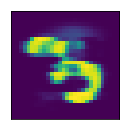

In [44]:
plt.figure(figsize=(2,2))
plt.imshow(sample)
plt.xticks([],[])
plt.yticks([],[])
plt.show()